In [63]:
import stdpopsim
from matplotlib import pyplot as plt
# Update default font sizes in rcParams
plt.rcParams.update({
    'font.size': 14,         # Default text size
    'axes.titlesize': 18,    # Title font size
    'axes.labelsize': 16,    # X and Y axis labels font size
    'xtick.labelsize': 12,   # X tick labels font size
    'ytick.labelsize': 12,   # Y tick labels font size
    'legend.fontsize': 14,   # Legend font size
    'figure.titlesize': 20   # Figure title font size
})

panel_size = 18

from glob import glob
import numpy as np
import pandas as pd
from dataclasses import dataclass
import seaborn as sns
from matplotlib.lines import Line2D

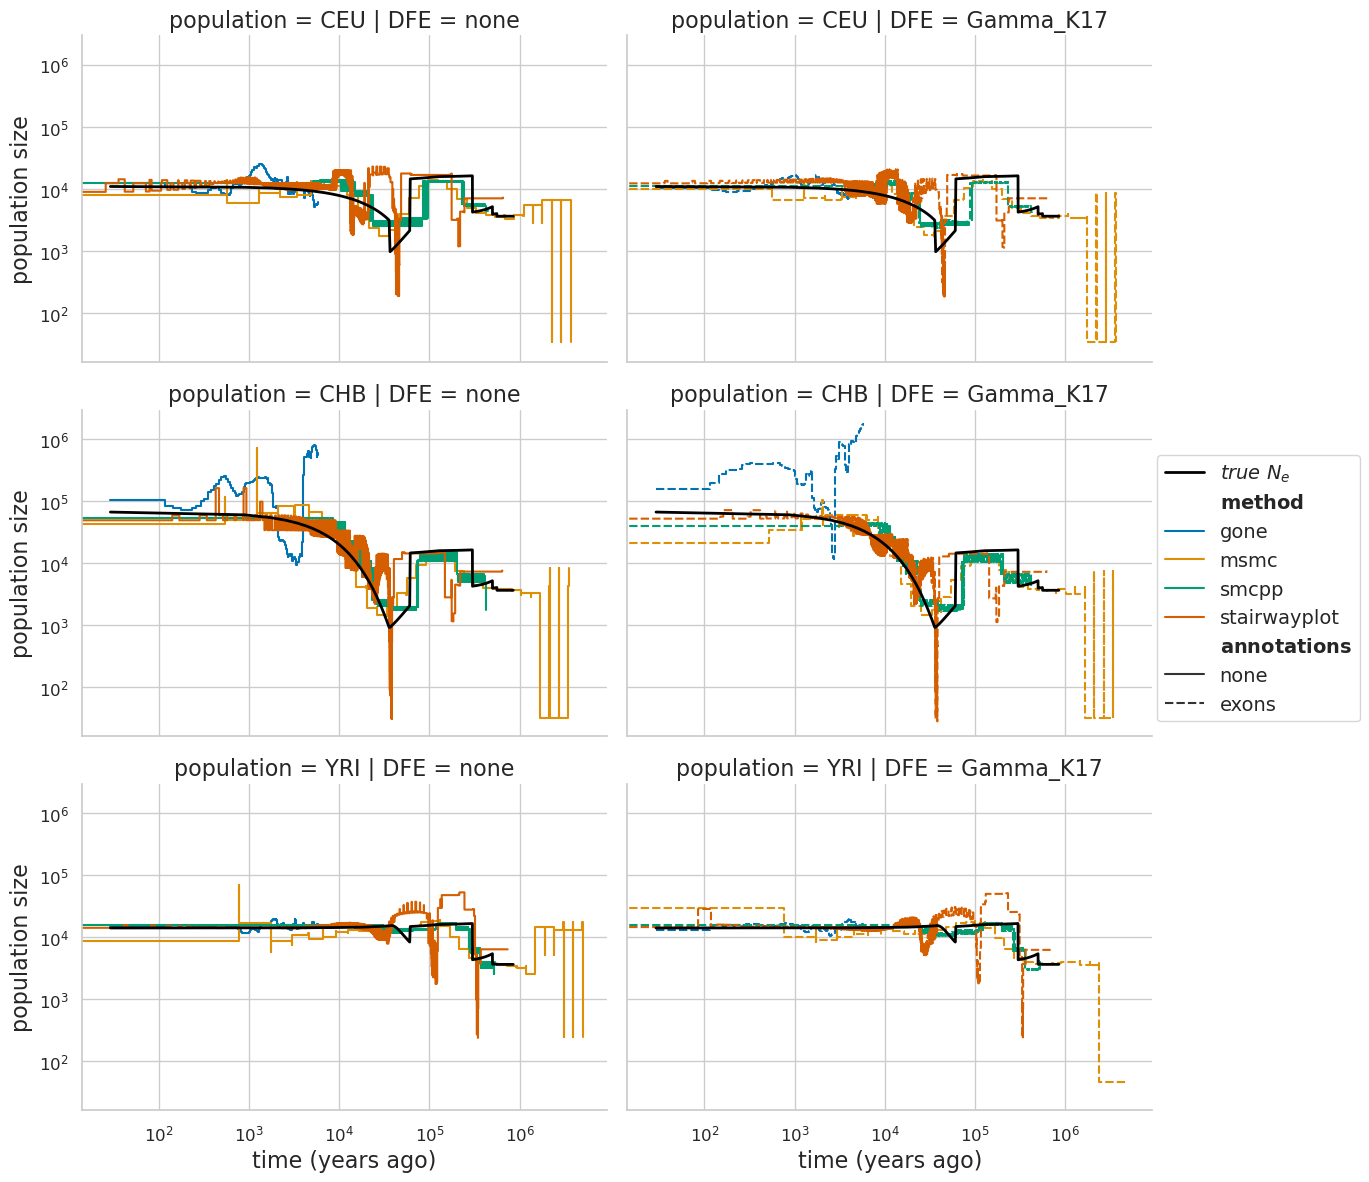

In [64]:
COLOURS = sns.color_palette("colorblind")
infile  = "/gpfs/projects/kernlab/stittes/analysis2/HomSap_results/plots/OutOfAfricaArchaicAdmixture_5R19/estimated_Ne_t_final.csv"
ref_line="coal"
colorby="method"
styleby="annotations"
log=True
df = pd.read_csv(infile, sep=",")
df['annotations'] = df['annotations'].replace('ensembl_havana_104_exons', 'exons')
df = df.query("annotations != 'none'")
df['annotations'] = df['annotations'].replace('all_sites', 'none')
#df = df.query("method == 'gone'")
df_ddb = pd.read_csv("/gpfs/projects/kernlab/stittes/analysis2/HomSap_results/plots/OutOfAfricaArchaicAdmixture_5R19/coal_estimated_Ne_t.csv")
df_ddb = df_ddb[df_ddb["method"] == ref_line]
pop_order = np.sort(df["population"].unique())
method_order = np.sort(df[colorby].unique())
pal_dict = {pop:COLOURS[i] for i, pop in enumerate(method_order)}
annot_order = np.sort(df[styleby].unique())[::-1]
dfe_order = np.sort(df["DFE"].unique())[::-1]
g = sns.relplot(data=df, x="year", y="Ne", 
                col="DFE", row="population",  # Swapped row and column
                col_order=list(dfe_order), row_order=list(pop_order),  # Also swap the corresponding orders
                hue=colorby, hue_order=method_order, 
                style=styleby, style_order=annot_order,
                kind="line", drawstyle='steps-pre',
                palette=pal_dict, errorbar=None, 
                height=4, aspect=1.5, facet_kws=dict(sharex=True, sharey=True),
                alpha = 1.0)  # Move legend outside of the plot
                # add ref_line to all plots x pop name

# Remove the existing legend
g._legend.remove()

# Collect handles and labels from all subplots
handles, labels = [], []
for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while preserving order
unique_handles, unique_labels = [], []
seen = set()
for h, l in zip(handles, labels):
    # Underline the "method" label
    if l == "method":
        l = r"$\mathbf{method}$"

    if l == "annotations":
        l = r"$\mathbf{annotations}$"

    if l not in seen:
        unique_handles.append(h)
        unique_labels.append(l)
        seen.add(l)

# Create a new legend outside the plot with a separator
# Add a dummy handle and label as a separator
unique_handles.append(plt.Line2D([0], [0], visible=False))  # Invisible line
#unique_labels.append('')  # Empty string for separator

# Add true line as the last element
for i, ax in enumerate(g.axes.flat):
    pop_ax = ax.title.get_text().split()[2]
    df_ddb_pop = df_ddb.query(f"population == '{pop_ax}'")
    true_handle = ax.plot(df_ddb_pop["year"], df_ddb_pop["Ne"], color="black", label="$true\ N_e$", linewidth=2)
unique_labels.insert(0, "$true\ N_e$")
unique_handles.insert(0, true_handle[0])

g.fig.legend(unique_handles, unique_labels, 
             loc='center left', 
             bbox_to_anchor=(0.85, 0.5), 
             ncol=1)

if log:
    g.set(xscale="log", yscale="log")
g.set_xlabels("time (years ago)")
g.set_ylabels("population size")
plt.savefig("estimated_Ne_t_final.pdf")
plt.show()

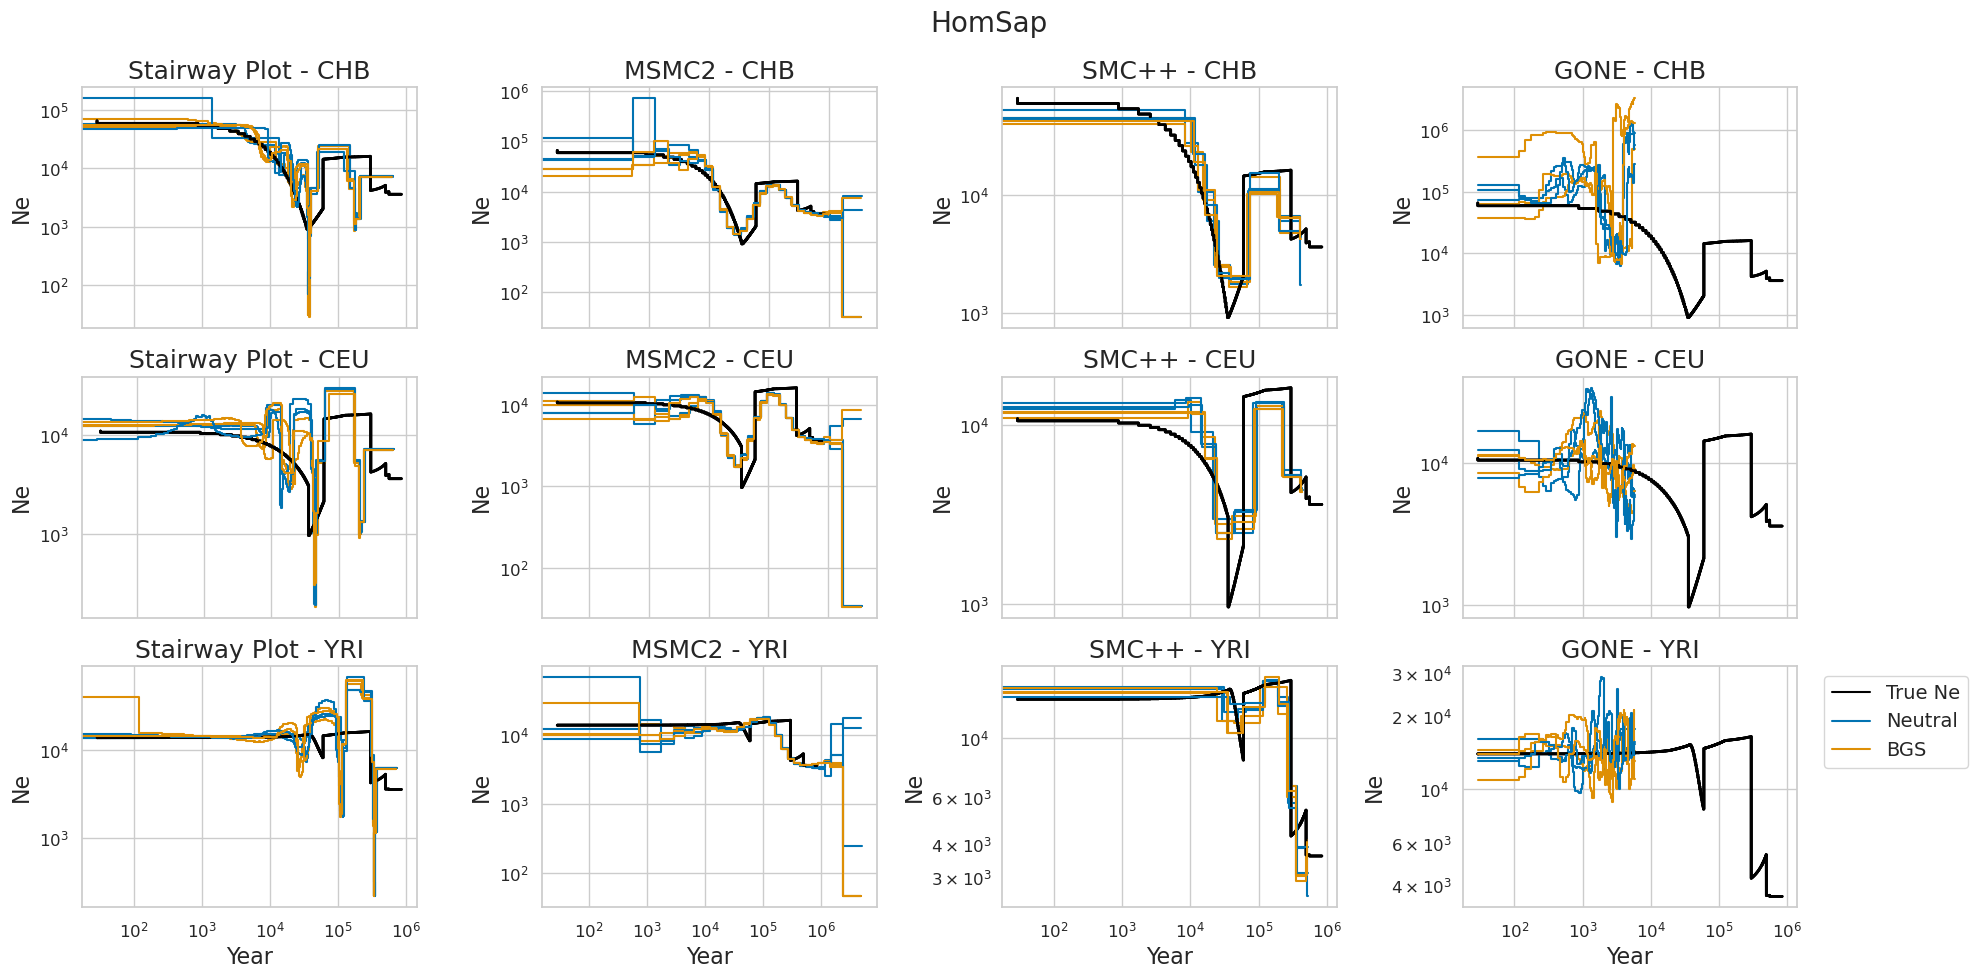

In [65]:
COLOURS = sns.color_palette("colorblind")
infile  = "/gpfs/projects/kernlab/stittes/analysis2/HomSap_results/plots/OutOfAfricaArchaicAdmixture_5R19/estimated_Ne_t_final.csv"
ref_line="coal"
colorby="annotations"
styleby="method"
log=True
df = pd.read_csv(infile, sep=",")
df['annotations'] = df['annotations'].replace('ensembl_havana_104_exons', 'exons')
df = df.query("annotations != 'none'")
df['annotations'] = df['annotations'].replace('all_sites', 'none')
#df = df.query("method == 'gone'")
df_ddb = pd.read_csv("/gpfs/projects/kernlab/stittes/analysis2/HomSap_results/plots/OutOfAfricaArchaicAdmixture_5R19/coal_estimated_Ne_t.csv")
df_ddb

# Create the figure and axes using subplots
methods = df['method'].unique()
method_dict = {"gone": "GONE", "smcpp": "SMC++", "msmc": "MSMC2", "stairwayplot": "Stairway Plot"}
populations = df['population'].unique()

fig, axes = plt.subplots(
    nrows=len(populations), 
    ncols=len(methods), 
    figsize=(20, 10), 
    squeeze=False
)

# Color palette for annotations
dfes = df['DFE'].unique()
COLOURS = sns.color_palette("colorblind")
color_dict = dict(zip(dfes, COLOURS))

seeds = df['seed'].unique()
# Plot for each method and population combination
for i, pop in enumerate(populations):
    for j, method in enumerate(methods):
        for seed in seeds:
            ax = axes[i, j]
            
            # Filter data for current method and population
            subset = df.query(f"population == '{pop}' & method == '{method}' & seed == {seed}")
            
            df_ddb_pop = df_ddb.query(f"population == '{pop}' & method == '{ref_line}'")
            true_handle = ax.step(df_ddb_pop["year"], df_ddb_pop["Ne"], color="black", label="$true\ N_e$", linewidth=2)

            # Plot each annotation group
            for dfe in dfes:
                annot_data = subset[subset['DFE'] == dfe]
                ax.step(annot_data['year'], annot_data['Ne'], 
                        where='pre', 
                        label=dfe, 
                        color=color_dict[dfe])
            
            #ax.set_xlim(-1e2, df_ddb_pop["year"].max())
            #ax.set_ylim(df_ddb_pop["Ne"].min()*0.5, df_ddb_pop["Ne"].max()*1.5)
            method_name = method_dict[method]
            ax.set_title(f'{method_name} - {pop}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Ne')
            #log scale both axes
            ax.set_xscale('log')
            ax.set_yscale('log')
            if pop != populations[-1]:
                ax.set_xlabel('')
                ax.set_xticklabels([])
                
# Only add legend to last subplot
# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', label='True Ne'),
    Line2D([0], [0], label='Neutral', color=color_dict['none']),
    Line2D([0], [0], label='BGS', color=color_dict['Gamma_K17'])
]

ax.legend(title='', handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("HomSap")
plt.tight_layout()
plt.savefig("estimated_Ne_t_final.pdf")
plt.show()


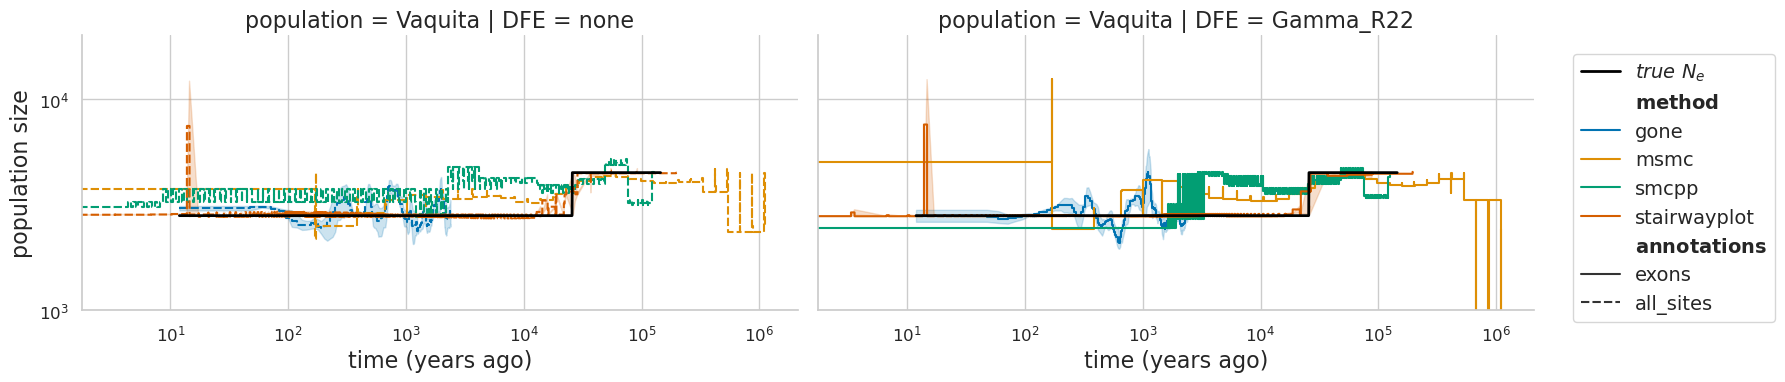

In [66]:
COLOURS = sns.color_palette("colorblind")
infile  = "/gpfs/projects/kernlab/stittes/analysis2/PhoSin_results/plots/Vaquita2Epoch_1R22/estimated_Ne_t_final.csv"
ref_line="coal"
colorby="method"
styleby="annotations"
log=True
df = pd.read_csv(infile, sep=",")
df['annotations'] = df['annotations'].replace('Phocoena_sinus.mPhoSin1.pri.110_exons', 'exons')
#df['annotations'] = df['annotations'].replace('all_sites', 'none')
#df = df.query("annotations != 'all_sites'")
df_ddb = pd.read_csv("/gpfs/projects/kernlab/stittes/analysis2/PhoSin_results/plots/Vaquita2Epoch_1R22/coal_estimated_Ne_t.csv")
df_ddb = df_ddb[df_ddb["method"] == ref_line]
pop_order = np.sort(df["population"].unique())
method_order = np.sort(df[colorby].unique())
pal_dict = {pop:COLOURS[i] for i, pop in enumerate(method_order)}
annot_order = np.sort(df[styleby].unique())[::-1]
dfe_order = np.sort(df["DFE"].unique())[::-1]
g = sns.relplot(data=df, x="year", y="Ne", 
                col="DFE", row="population",  # Swapped row and column
                col_order=list(dfe_order), row_order=list(pop_order),  # Also swap the corresponding orders
                hue=colorby, hue_order=method_order, 
                style=styleby, style_order=annot_order,
                kind="line", drawstyle='steps-pre',
                palette=pal_dict, errorbar="se", err_style="band", 
                height=4, aspect=2, facet_kws=dict(sharex=True, sharey=True),
                alpha = 1.0)  # Move legend outside of the plot
                # add ref_line to all plots x pop name

# Remove the existing legend
g._legend.remove()

# Collect handles and labels from all subplots
handles, labels = [], []
for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while preserving order
unique_handles, unique_labels = [], []
seen = set()
for h, l in zip(handles, labels):
    # Underline the "method" label
    if l == "method":
        l = r"$\mathbf{method}$"

    if l == "annotations":
        l = r"$\mathbf{annotations}$"

    if l not in seen:
        unique_handles.append(h)
        unique_labels.append(l)
        seen.add(l)

# Create a new legend outside the plot with a separator
# Add a dummy handle and label as a separator
unique_handles.append(plt.Line2D([0], [0], visible=False))  # Invisible line
#unique_labels.append('')  # Empty string for separator

# Add true line as the last element
for i, ax in enumerate(g.axes.flat):
    pop_ax = ax.title.get_text().split()[2]
    df_ddb_pop = df_ddb.query(f"population == '{pop_ax}'")
    true_handle = ax.plot(df_ddb_pop["year"], df_ddb_pop["Ne"], color="black", label="$true\ N_e$", linewidth=2)
unique_labels.insert(0, "$true\ N_e$")
unique_handles.insert(0, true_handle[0])

g.fig.legend(unique_handles, unique_labels, 
             loc='center left', 
             bbox_to_anchor=(0.9, 0.5), 
             ncol=1)

if log:
    g.set(xscale="log", yscale="log")
g.set_xlabels("time (years ago)")
g.set_ylabels("population size")

#x limits
g.set(ylim=(1e3, 2e4))

plt.savefig("vaquita_estimated_Ne_t_final.pdf")
plt.show()

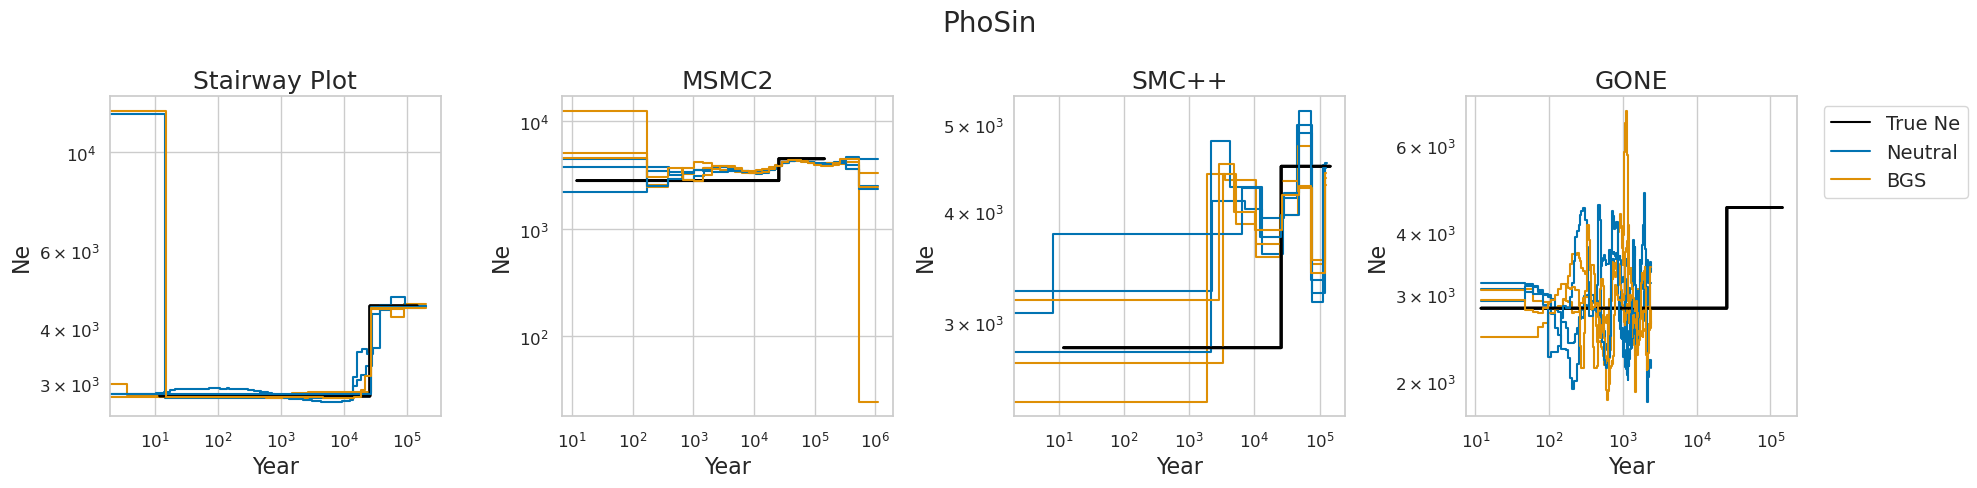

In [67]:
COLOURS = sns.color_palette("colorblind")
infile  = "/gpfs/projects/kernlab/stittes/analysis2/PhoSin_results/plots/Vaquita2Epoch_1R22/estimated_Ne_t_final.csv"
ref_line="coal"
colorby="annotations"
styleby="method"
log=True
df = pd.read_csv(infile, sep=",")
df['annotations'] = df['annotations'].replace('Phocoena_sinus.mPhoSin1.pri.110_exons', 'exons')
#df['annotations'] = df['annotations'].replace('all_sites', 'none')
#df = df.query("annotations != 'all_sites'")
df_ddb = pd.read_csv("/gpfs/projects/kernlab/stittes/analysis2/PhoSin_results/plots/Vaquita2Epoch_1R22/coal_estimated_Ne_t.csv")
df_ddb = df_ddb[df_ddb["method"] == ref_line]
pop_order = np.sort(df["population"].unique())
method_order = np.sort(df[colorby].unique())
pal_dict = {pop:COLOURS[i] for i, pop in enumerate(method_order)}
annot_order = np.sort(df[styleby].unique())[::-1]
dfe_order = np.sort(df["DFE"].unique())[::-1]

# Create the figure and axes using subplots
methods = df['method'].unique()
populations = df['population'].unique()

fig, axes = plt.subplots(
    nrows=len(populations), 
    ncols=len(methods), 
    figsize=(20, 5), 
    squeeze=False
)

# Color palette for annotations
dfes = df['DFE'].unique()
COLOURS = sns.color_palette("colorblind")
color_dict = dict(zip(dfes, COLOURS))

seeds = df['seed'].unique()
# Plot for each method and population combination
for i, pop in enumerate(populations):
    for j, method in enumerate(methods):
        for seed in seeds:
            ax = axes[i, j]
            
            # Filter data for current method and population
            subset = df.query(f"population == '{pop}' & method == '{method}' & seed == {seed}")
            
            df_ddb_pop = df_ddb.query(f"population == '{pop}' & method == '{ref_line}'")
            true_handle = ax.step(df_ddb_pop["year"], df_ddb_pop["Ne"], color="black", label="$true\ N_e$", linewidth=2)

            # Plot each annotation group
            for dfe in dfes:
                annot_data = subset[subset['DFE'] == dfe]
                ax.step(annot_data['year'], annot_data['Ne'], 
                        where='pre', 
                        label=dfe, 
                        color=color_dict[dfe])
            
            #ax.set_xlim(-1e2, df_ddb_pop["year"].max())
            #ax.set_ylim(df_ddb_pop["Ne"].min()*0.5, df_ddb_pop["Ne"].max()*1.5)
            method_name = method_dict[method]
            ax.set_title(f'{method_name}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Ne')
            #log scale both axes
            ax.set_xscale('log')
            ax.set_yscale('log')
            if pop != populations[-1]:
                ax.set_xlabel('')
                ax.set_xticklabels([])
                

                
# Only add legend to last subplot
# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', label='True Ne'),
    Line2D([0], [0], label='Neutral', color=color_dict['none']),
    Line2D([0], [0], label='BGS', color=color_dict['Gamma_R22'])
]

ax.legend(title='', handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("PhoSin")
plt.tight_layout()
plt.savefig("vaquita_estimated_Ne_t_final.pdf")
plt.show()


In [68]:
#df.query("annotations == 'all_sites'")
df.annotations.unique()

array(['all_sites', 'exons'], dtype=object)

In [90]:
@dataclass
class SpeciesInfo:
    """
    Class to store information about species, dfe, demog, and annotation

    species: str - species name
    neu_prop: float - proportion of neutral sites
    nonneu_prop: float - proportion of non-neutral sites
    basedir: str - directory where results are stored
    demog: str - demographic model
    dfe: str - dfe model
    annot: str - annotation used
    """
    species: str
    basedir: str
    demog: str
    dfe: str
    annot: str
    neu_prop: float = 0.3
    nonneu_prop: float = 0.7

    def __post_init__(self):
        self.get_species_info()
        self.make_dfe_dataframe()

    def get_species_info(self):
        species = stdpopsim.get_species(self.species)
        
        if self.annot == "all_sites":
            seq_len = sum([g.length for g in species.genome.chromosomes if g.id not in ["Y", "MT"]])
            annotations = np.array([[0,g.length] for g in species.genome.chromosomes if g.id not in ["Y", "MT"]])
        else:
            annotations = species.get_annotations(self.annot)
            seq_len = 0
            for g in species.genome.chromosomes:
                if g.id not in ["Y", "MT"]:        
                    annot_intervals = annotations.get_chromosome_annotations(g.id)
                    seq_len+= sum([abs(i[1]-i[0]) for i in annot_intervals])
        dfe = species.get_dfe(self.dfe)
        try:
            model = species.get_demographic_model(self.demog)
            if model.mutation_rate is not None:
                mutation_rate = model.mutation_rate
            else:
                mutation_rate = species.genome.mean_mutation_rate
        except:
            mutation_rate = species.genome.mean_mutation_rate
            
        dfe_params = dfe.mutation_types[-1].distribution_args
        self.dfe_params = dfe_params
        self.mutation_rate = mutation_rate
        self.seq_len = seq_len
        self.species_id = species

    def get_loss(self):
        def mae(variable, truth):
            return np.mean(np.abs(variable - truth))

        Es, shape = self.dfe_params
        Es = np.abs(Es)
        mae_Es = self.all_DFE.groupby(['method'])[['Es']].agg(lambda x: mae(x, Es)).reset_index()
        mae_shape = self.all_DFE.groupby(['method'])[['shape']].agg(lambda x: mae(x, shape)).reset_index()
        loss_df = pd.merge(mae_Es, mae_shape, on = 'method')
        lenz = len(loss_df)
        return pd.DataFrame({'MAE E|s|': loss_df['Es'].values,
                'MAE shape': loss_df['shape'].values,
                'method': loss_df['method'].values,
                'species ID': [self.species]*lenz,
                'demography': [self.demog]*lenz,
                'annotation': [self.annot]*lenz})

    ## Rescaling functions
    def grapes_rescale(self, df):
        df['Es'] = df['Es'] * self.mutation_rate / df['theta']
        df['method'] = 'grapes'
        return df

    def dfe_alpha_rescale(self, df):
        df['shape'] = df['b']
        df['Es'] = abs(df['Es'])
        df['method'] = "DFE-alpha"
        return df

    def polydfe_rescale(self, df):
        df['shape'] = df['b']
        df['Es'] = 2 * abs(self.mutation_rate * df['S_d'] / df['theta_bar'])
        df['method'] = "polyDFE" 
        return df 

    def dadi_rescale(self, df):
        df['Es'] = df['shape'] * df['scale'] / (df['theta'] / (4 * self.mutation_rate * self.seq_len * self.nonneu_prop))
        df['method'] = 'dadi'
        return df

    def make_dfe(self, method):
        input_files = glob(f"../{self.basedir}/inference/{self.demog}/{method}/{self.dfe}/{self.annot}/*/*/*bestfit")
        df = pd.concat([pd.read_csv(i, sep="\t") for i in input_files])
        if method == "grapes":
            df = self.grapes_rescale(df)
        elif method == "DFE-alpha":
            df = self.dfe_alpha_rescale(df)
        elif method == "polyDFE":
            df = self.polydfe_rescale(df)
        elif method == "dadi":
            df = self.dadi_rescale(df)
        else:
            raise ValueError(f"Method {method} not recognized")
        return df
    
    def make_dfe_dataframe(self):
        if self.demog == "Constant":
            pop_dict = {f"pop{0}":0}
        else:
            model = self.species_id.get_demographic_model(self.demog)
            pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}

        all_DFE = pd.concat([self.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
        #make new name columns for viz
        all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
        #update dadi to be dadi-cli in method column
        all_DFE['method'] = all_DFE['method'].replace('dadi', 'dadi-cli')
        self.all_DFE = all_DFE


def make_some_plots(species_info: SpeciesInfo, output_path = None, hide_legend = False):
    if output_path is None:
        output_path = f"{species_info.species}_{species_info.demog}_{species_info.dfe}_{species_info.annot}_DFE_plot.pdf"
    
    fig, axes = plt.subplot_mosaic(
        '''
        AB
        ''',
        figsize=(13, 6)
    )
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

    #all_DFE = pd.concat([species_info.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
    #make new name columns for viz
    #all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
    #seaborn boxplot method vs. Es split by pop_id no lines, no error bars
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    
    #
    sns.boxplot(x="method", y="Es", hue = 'pop', data=species_info.all_DFE, 
                showfliers=False,  # Hide outlier points
                showbox=False,     # Hide the box
                showcaps=False,    # Hide the caps
                whis=0,
                linewidth=2,
                linecolor='black',
                ax = axes['A'])

    sns.stripplot(x="method", y="Es", hue = 'pop', data=species_info.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['A'])
    
    #horizontal line at 0 on axes A
    axes['A'].axhline(abs(species_info.dfe_params[0]), color='black', linestyle='--')
    axes['A'].set_ylabel('|E(s)|')  
    axes['A'].set_xlabel('Method')
    axes['A'].set_title("A", loc = "left", fontsize=panel_size)

    #seaborn boxplot method vs. Es split by pop_id no lines, no error bars
    sns.set_theme(style="whitegrid")
    sns.boxplot(x="method", y="shape", hue = 'pop', data=species_info.all_DFE,
                showfliers=False,  # Hide outlier points
                showbox=False,     # Hide the box
                showcaps=False,    # Hide the caps
                whis=0,
                linewidth=2,
                linecolor='black',
                ax = axes['B'])

    sns.stripplot(x="method", y="shape", hue = 'pop', data=species_info.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['B'])
    #horizontal line at 0
    axes['B'].axhline(abs(species_info.dfe_params[1]), color='black', linestyle='--')
    axes['B'].set_title("B", loc = "left", fontsize=panel_size)
    axes['B'].set_ylabel('Shape')
    axes['A'].set_xlabel('Method')

    
    fig.suptitle(f"{species_info.species}")
    if hide_legend:
        axes['A'].get_legend().remove()
        axes['B'].get_legend().remove()
        
    plt.savefig(output_path)


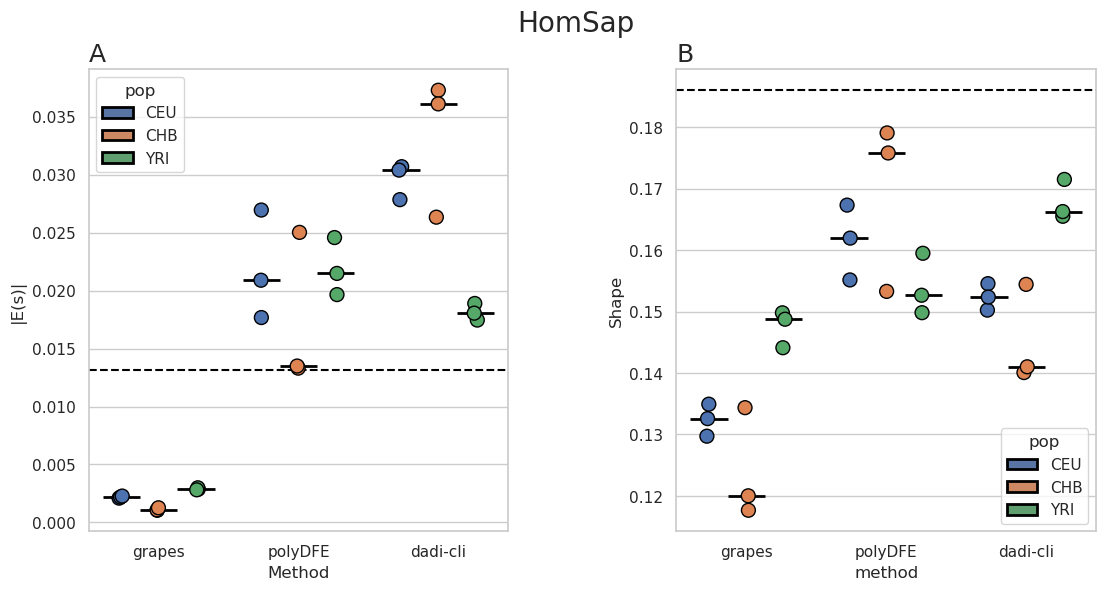

In [91]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "OutOfAfricaArchaicAdmixture_5R19",
    dfe = "Gamma_K17",
    annot = "ensembl_havana_104_exons"
)

#model = stdpopsim.get_species("HomSap").get_demographic_model(hom_sap.demog)
#pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}
make_some_plots(hom_sap)

loss_list = []
loss_list.append(hom_sap.get_loss())


/tmp/ipykernel_4120318/6669919.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_data['pop'] = pd.Categorical(method_data['pop'], categories=pop_order, ordered=True)
/tmp/ipykernel_4120318/6669919.py:188: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipykernel_4120318/6669919.py:188: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
/tmp/ipykernel_4120318/6669919.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_4120318/

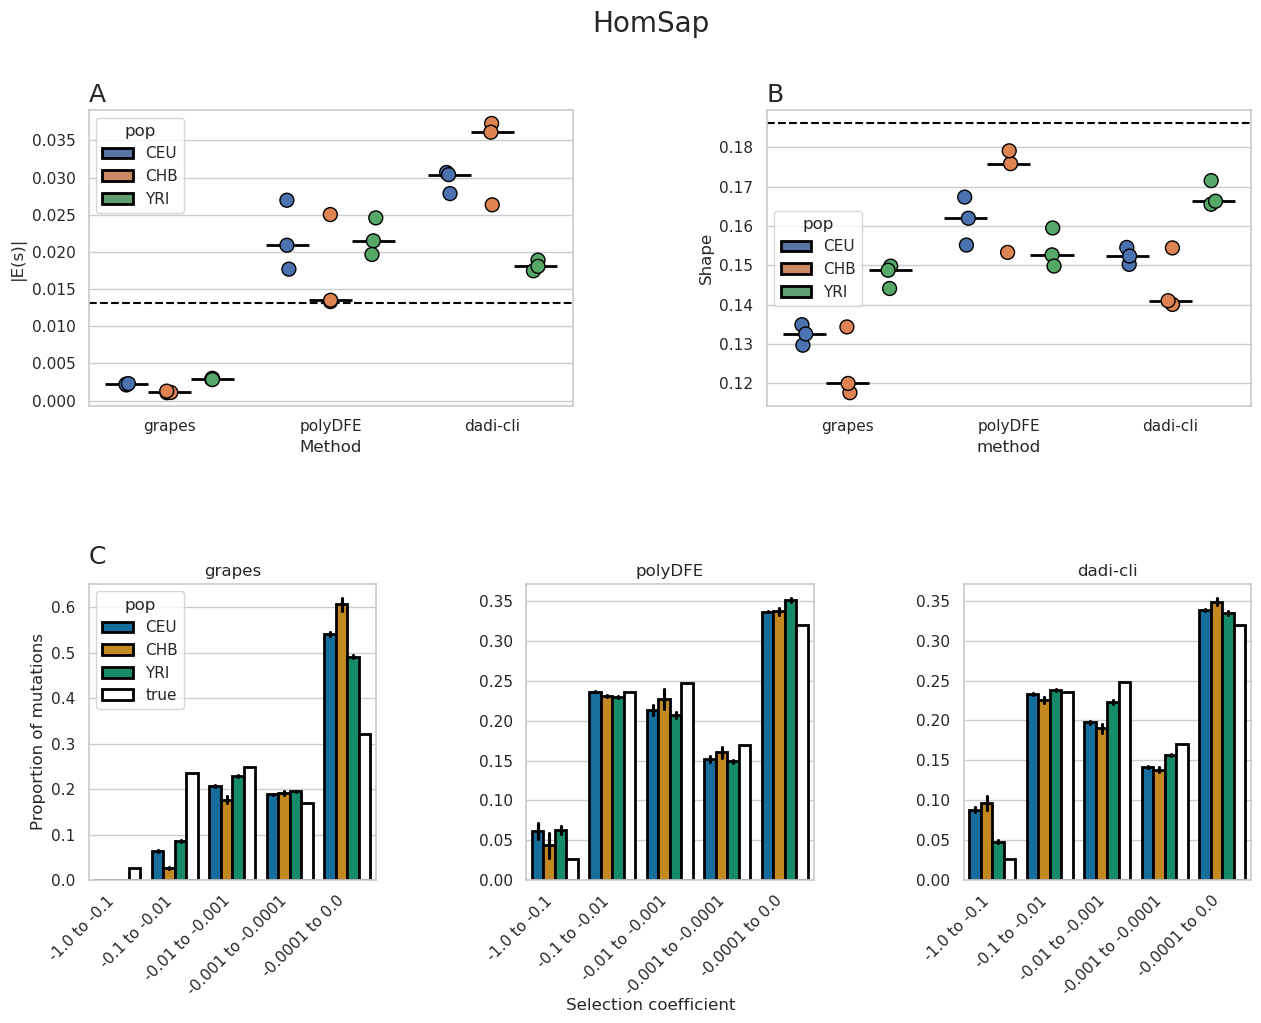

In [94]:
import numpy as np
import scipy.stats.distributions as ssd
from scipy import stats
import stdpopsim


hom_sap
Es, shape = hom_sap.dfe_params

def mae(variable, truth):
        return np.mean(np.abs(variable - truth))

mae_Es = hom_sap.all_DFE.groupby(['method'])[['Es']].agg(lambda x: mae(x, Es)).reset_index()
mae_shape = hom_sap.all_DFE.groupby(['method'])[['shape']].agg(lambda x: mae(x, shape)).reset_index()
loss_df = pd.merge(mae_Es, mae_shape, on = 'method')
lenz = len(loss_df)
pd.DataFrame({'MAE E|s|': loss_df['Es'].values,
        'MAE shape': loss_df['shape'].values,
        'method': loss_df['method'].values,
        'species ID': [hom_sap.species]*lenz,
        'demography': [hom_sap.demog]*lenz,
        'annotation': [hom_sap.annot]*lenz})

#print(hom_sap.all_DFE.query('method == "polyDFE"')['mae_Es'].reset_index().mean())
#hom_sap.all_DFE.query('method == "dadi"')['mae_Es'].reset_index().mean()

def get_mut_props(speciesinfo: SpeciesInfo, method, pop, bins):
    Ne = 1 #stdpopsim.get_species(speciesinfo.species).population_size

    if method == "true":
        pop = "true"
        popmethod_shape = speciesinfo.dfe_params[1]
        gamma_scale = - Ne * speciesinfo.dfe_params[0]/speciesinfo.dfe_params[1]
        
        # For "true" method, we still have single values
        inferred_bins = ssd.gamma.cdf(bins[1:], a=popmethod_shape, scale=gamma_scale) - ssd.gamma.cdf(bins[:-1], a=popmethod_shape, scale=gamma_scale)
        bins_df = pd.DataFrame({
            'bin_start': bins[:-1], 
            'bin_end': bins[1:], 
            'prop': inferred_bins, 
            'pop': pop, 
            'method': method
        })
        bins_df['bin_start'] = bins_df['bin_start'] * -1
        bins_df['bin_end'] = bins_df['bin_end'] * -1
        return bins_df
    
    else:
        # Get all values instead of means
        popmethod_Es_values = speciesinfo.all_DFE.query('method == @method & pop == @pop')['Es'].values
        popmethod_shape_values = speciesinfo.all_DFE.query('method == @method & pop == @pop')['shape'].values
        gamma_scale_values = Ne * popmethod_Es_values / popmethod_shape_values
        
        # Create a list to store all results
        all_bins_dfs = []
        
        # Calculate proportions for each set of parameters
        for i, (shape, scale) in enumerate(zip(popmethod_shape_values, gamma_scale_values)):
            inferred_bins = ssd.gamma.cdf(bins[1:], a=shape, scale=scale) - ssd.gamma.cdf(bins[:-1], a=shape, scale=scale)
            bins_df = pd.DataFrame({
                'bin_start': bins[:-1], 
                'bin_end': bins[1:], 
                'prop': inferred_bins, 
                'pop': pop, 
                'method': method,
                'replicate': i  # Add replicate identifier
            })
            bins_df['bin_start'] = bins_df['bin_start'] * -1
            bins_df['bin_end'] = bins_df['bin_end'] * -1
            all_bins_dfs.append(bins_df)
        
        # Combine all results
        final_df = pd.concat(all_bins_dfs, ignore_index=True)
        return final_df



#binz = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, -np.inf]
binz = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
#binz = [np.inf, 1000, 100, 10, 1, 0]
all_bin_df =  pd.concat([
           get_mut_props(hom_sap, "true", "CEU", binz), 
           get_mut_props(hom_sap, "grapes", "CEU", binz), 
           get_mut_props(hom_sap, "dadi-cli", "CEU", binz),
           get_mut_props(hom_sap, "polyDFE", "CEU", binz),
           get_mut_props(hom_sap, "true", "CHB", binz), 
           get_mut_props(hom_sap, "grapes", "CHB", binz), 
           get_mut_props(hom_sap, "dadi-cli", "CHB", binz),
           get_mut_props(hom_sap, "polyDFE", "CHB", binz),
           get_mut_props(hom_sap, "true", "YRI", binz), 
           get_mut_props(hom_sap, "grapes", "YRI", binz), 
           get_mut_props(hom_sap, "dadi-cli", "YRI", binz),
           get_mut_props(hom_sap, "polyDFE", "YRI", binz),
])


layout = [
    ['A', 'B'],
    ['C', 'C']
]

fig, axes = plt.subplot_mosaic(
    layout,
    figsize=(15, 10),
    #white space between subplots
    gridspec_kw={'wspace': 0.4, 'hspace': 0.6}
)


sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Get an existing palette
palette = sns.color_palette("colorblind", 5)

# Modify a specific color (e.g., change the third color)
palette[3] = (1.0, 1.0, 1.0)  # RGB for red


import seaborn as sns
sns.set_theme(style="whitegrid")

#
sns.boxplot(x="method", y="Es", hue = 'pop', data=hom_sap.all_DFE, 
            showfliers=False,  # Hide outlier points
            showbox=False,     # Hide the box
            showcaps=False,    # Hide the caps
            whis=0,
            linewidth=2,
            linecolor='black',
            ax = axes['A'])

sns.stripplot(x="method", y="Es", hue = 'pop', data=hom_sap.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['A'])

#horizontal line at 0 on axes A
axes['A'].axhline(abs(hom_sap.dfe_params[0]), color='black', linestyle='--')
axes['A'].set_ylabel('|E(s)|')  
axes['A'].set_xlabel('Method')
axes['A'].set_title("A", loc = "left", fontsize=panel_size)


sns.boxplot(x="method", y="shape", hue = 'pop', data=hom_sap.all_DFE,
            showfliers=False,  # Hide outlier points
            showbox=False,     # Hide the box
            showcaps=False,    # Hide the caps
            whis=0,
            linewidth=2,
            linecolor='black',
            ax = axes['B'])

sns.stripplot(x="method", y="shape", hue = 'pop', data=hom_sap.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['B'])
#horizontal line at 0
axes['B'].axhline(abs(hom_sap.dfe_params[1]), color='black', linestyle='--')
axes['B'].set_title("B", loc = "left", fontsize=panel_size)
axes['B'].set_ylabel('Shape')
axes['A'].set_xlabel('Method')

# Get the position of panel C
pos = axes['C'].get_position()
axes['C'].remove()  # Remove the original C axes

# Create new axes for each method
methods = ['grapes', 'polyDFE', 'dadi-cli']
n_plots = len(methods)

# Add spacing between subplots
spacing = 0.1  # Adjust this value to change spacing between subplots
total_spacing = spacing * (n_plots - 1)
width = (pos.width - total_spacing) / n_plots

c_axes = []
for i, method in enumerate(methods):
    ax = fig.add_axes([
        pos.x0 + i * (width + spacing),  # x position with spacing
        pos.y0,                          # y position
        width,                           # width
        pos.height                       # height
    ])

    # Filter data for this method
    method_data = all_bin_df.query(f"method in ['{method}', 'true']")

    #custom sort pop
    pop_order = ['CEU', 'CHB', 'YRI', 'true']
    method_data['pop'] = pd.Categorical(method_data['pop'], categories=pop_order, ordered=True)

    # Create the barplot
    sns.barplot(
        data=method_data,
        x='bin_start',
        y='prop',
        hue='pop',  # Changed from 'method' to 'pop'
        palette=palette,
        edgecolor="black", linewidth=2,
        errorbar='se',
        errcolor = "black",
        order=sorted(all_bin_df['bin_start'].unique()),
        ax=ax
    )

    # Customize each subplot
    bin_starts = sorted(method_data['bin_start'].unique())
    bin_starts[-1] = 0.0 #remove -0
    bin_ends = method_data.drop_duplicates('bin_start').sort_values('bin_start')['bin_end']
    labels = [f"{end:,} to {start:,}" for start, end in zip(bin_starts, bin_ends)]

    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f'{method}')
    ax.set_ylabel('Proportion of mutations')

    # Only show legend for the first subplot
    if i != 0:
        ax.get_legend().remove()
        ax.set_ylabel('')
    ax.set_xlabel('')

# Calculate position for the title
title_x = pos.x0  # Left edge of the C panel
title_y = pos.y0 + pos.height + 0.02  # Just above the plots, adjust 0.02 as needed

# Add the title
fig.text(title_x, title_y, 'C', fontsize=panel_size)

#common axis labels
fig.text(0.5, -0.02, 'Selection coefficient', ha='center')

# Adjust layout
plt.tight_layout()
fig.suptitle(f"{hom_sap.species}")
plt.savefig("HomSap_discrete_DFE.pdf")
plt.show()


In [72]:
method_data

,bin_start,bin_end,prop,pop,method,replicate
0,-0.0000,-0.0001,0.320029,true,true,NaN
1,-0.0001,-0.0010,0.170116,true,true,NaN
2,-0.0010,-0.0100,0.247603,true,true,NaN
3,-0.0100,-0.1000,0.236040,true,true,NaN
4,-0.1000,-1.0000,0.026213,true,true,NaN
0,-0.0000,-0.0001,0.341062,CEU,dadi-cli,0.0
1,-0.0001,-0.0010,0.140677,CEU,dadi-cli,0.0
2,-0.0010,-0.0100,0.195227,CEU,dadi-cli,0.0
3,-0.0100,-0.1000,0.231523,CEU,dadi-cli,0.0
4,-0.1000,-1.0000,0.091239,CEU,dadi-cli,0.0


In [73]:
all_bin_df

,bin_start,bin_end,prop,pop,method,replicate
0,-0.0000,-0.0001,0.320029,true,true,NaN
1,-0.0001,-0.0010,0.170116,true,true,NaN
2,-0.0010,-0.0100,0.247603,true,true,NaN
3,-0.0100,-0.1000,0.236040,true,true,NaN
4,-0.1000,-1.0000,0.026213,true,true,NaN
...,...,...,...,...,...,...
10,-0.0000,-0.0001,0.353524,YRI,polyDFE,2.0
11,-0.0001,-0.0010,0.145266,YRI,polyDFE,2.0
12,-0.0010,-0.0100,0.200510,YRI,polyDFE,2.0
13,-0.0100,-0.1000,0.228068,YRI,polyDFE,2.0


In [74]:
all_bin_df[all_bin_df['method'] == 'true']

,bin_start,bin_end,prop,pop,method,replicate
0,-0.0000,-0.0001,0.320029,true,true,NaN
1,-0.0001,-0.0010,0.170116,true,true,NaN
2,-0.0010,-0.0100,0.247603,true,true,NaN
3,-0.0100,-0.1000,0.236040,true,true,NaN
4,-0.1000,-1.0000,0.026213,true,true,NaN
0,-0.0000,-0.0001,0.320029,true,true,NaN
1,-0.0001,-0.0010,0.170116,true,true,NaN
2,-0.0010,-0.0100,0.247603,true,true,NaN
3,-0.0100,-0.1000,0.236040,true,true,NaN
4,-0.1000,-1.0000,0.026213,true,true,NaN


In [75]:
hom_sap.dfe_params

[-0.013148327678138633, 0.186]

In [76]:
all_bin_df.groupby(['method', 'pop', ])['prop'].sum()   

method    pop 
dadi-cli  CEU     2.999354
          CHB     2.998175
          YRI     2.999992
grapes    CEU     3.000000
          CHB     3.000000
          YRI     3.000000
polyDFE   CEU     2.999880
          CHB     2.999931
          YRI     2.999900
true      true    3.000000
Name: prop, dtype: float64

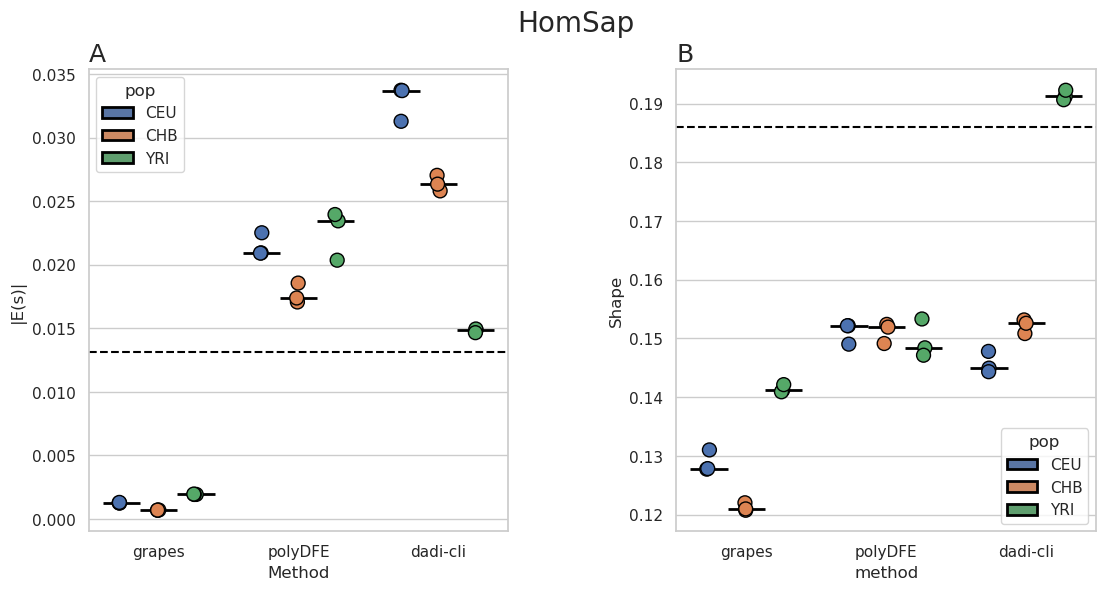

In [77]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "OutOfAfricaArchaicAdmixture_5R19",
    dfe = "Gamma_K17",
    annot = "all_sites"
)

model = stdpopsim.get_species("HomSap").get_demographic_model(hom_sap.demog)
pop_dict = {f"pop{i}":m.name for i,m in enumerate(model.populations[:3])}
make_some_plots(hom_sap)
loss_list.append(hom_sap.get_loss())


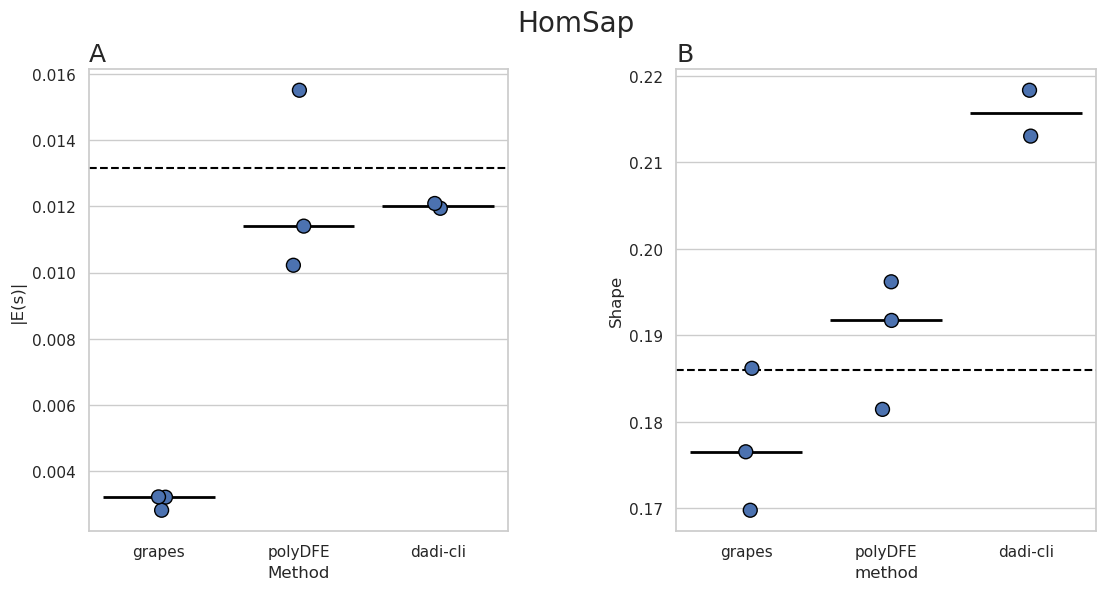

In [78]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "Constant",
    dfe = "Gamma_K17",
    annot = "ensembl_havana_104_exons"
)

make_some_plots(hom_sap, hide_legend = True)
loss_list.append(hom_sap.get_loss())

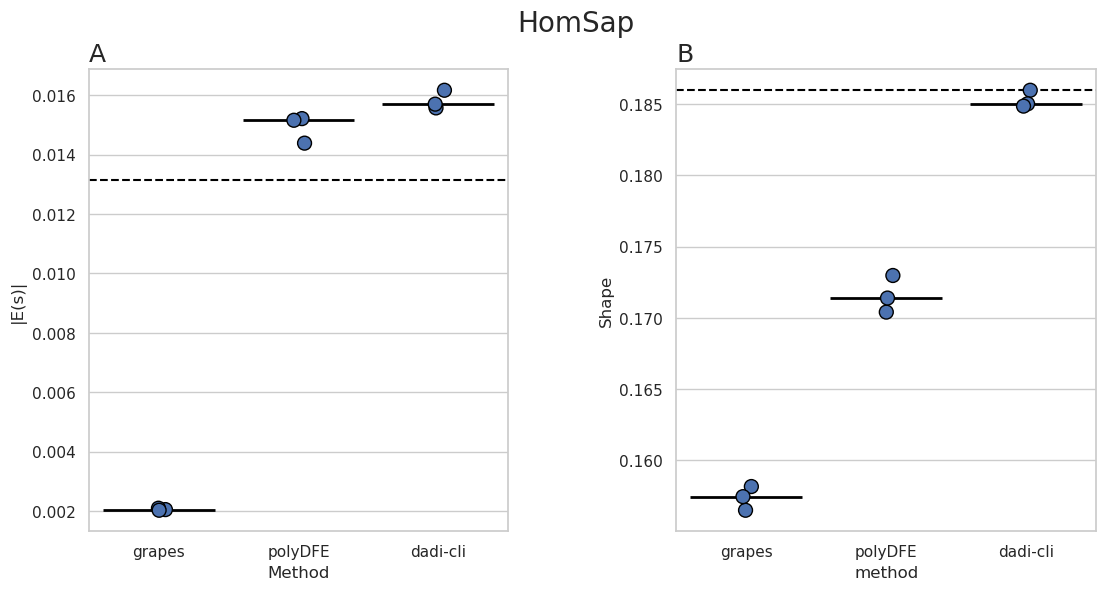

In [79]:
hom_sap = SpeciesInfo(
    species = "HomSap",
    basedir = "HomSap_results",
    demog = "Constant",
    dfe = "Gamma_K17",
    annot = "all_sites"
)

make_some_plots(hom_sap, hide_legend = True)
loss_list.append(hom_sap.get_loss())

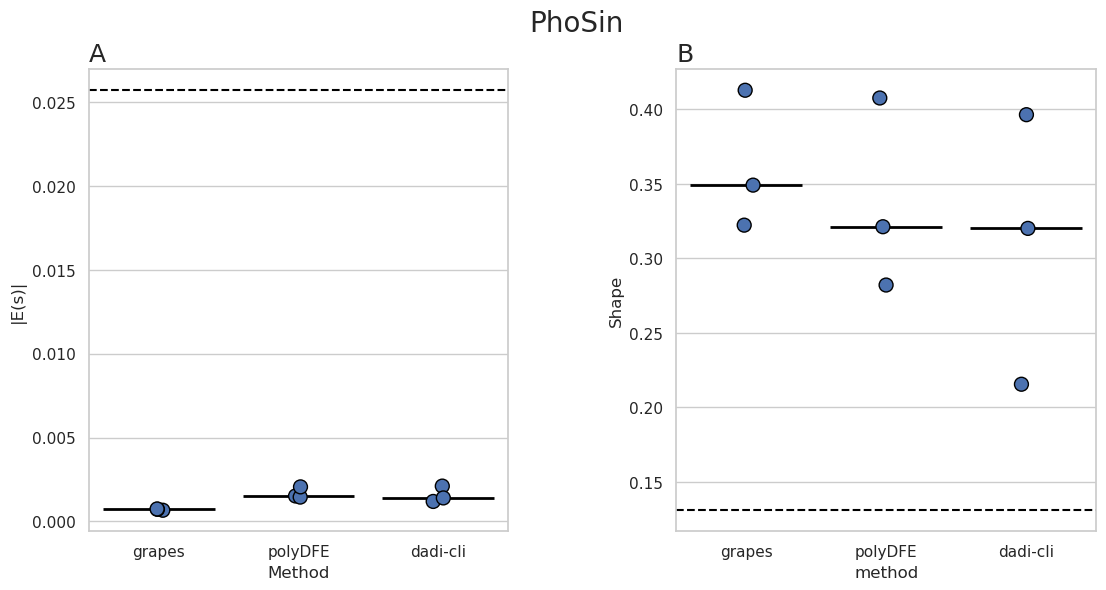

In [80]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Vaquita2Epoch_1R22",
    dfe = "Gamma_R22",
    annot = "Phocoena_sinus.mPhoSin1.pri.110_exons"
)

make_some_plots(pho_sin, hide_legend = True)
loss_list.append(pho_sin.get_loss())

## EXPLORING H-S RELATIONSHIP ISSUE

In [81]:
#previous version of code 

import numpy as np
import scipy.stats.distributions as ssd
import stdpopsim

def build_hs_plot(ax = None):
    Es = dict(pho_sin.all_DFE.groupby(['method'])[['Es']].agg('mean')["Es"])
    shape = dict(pho_sin.all_DFE.groupby(['method'])[['shape']].agg('mean')["shape"])
                
    phosin = stdpopsim.get_species("PhoSin")
    dfe = phosin.get_dfe("Gamma_R22")
    gamma_mean, gamma_shape = dfe.mutation_types[-1].distribution_args
    print(gamma_mean, gamma_shape)

    #Ryan Gutenkunst's code

    # From https://github.com/popsim-consortium/stdpopsim/blob/main/stdpopsim/catalog/PhoSin/dfes.py
    dominance_coeff_list=[0.0, 0.01, 0.1, 0.4]
    dominance_coeff_breaks=[-0.1, -0.01, -0.001]

    #number of draws for historgram 
    N = int(5e5)

    Ne = phosin.population_size

    # Construct the corresponding gamma distribution
    gamma_scale = -gamma_mean / gamma_shape
    dfe = ssd.gamma(gamma_shape, scale=gamma_scale)
    assert(dfe.mean() == abs(gamma_mean))

    # Simulate draws from the DFE
    s_array = -dfe.rvs(int(1e5))

    # Sanity check, using method of moments to recover simulated shape and scale.
    # (Fixing location parameter to zero.)
    # mean = shape * scale, var = shape * scale**2
    # So scale = var/mean, and shape = mean/scale
    fit_s_scale = s_array.var()/s_array.mean()
    fit_s_shape = s_array.mean()/fit_s_scale
    # Or just use fit_s_shape, _, fit_s_scale = ssd.gamma.fit(s_array, method='MM', floc=0) 
    print('Sanity check: Inferred s shape and mean: {0:.4f}, {1:.5f}'.format(fit_s_shape, fit_s_shape*fit_s_scale))

    # Convert to 2*hs
    breaks = [-np.inf] + list(dominance_coeff_breaks) + [0]
    hs_arrays = []
    for h, s_start, s_end in zip(dominance_coeff_list, breaks[:-1], breaks[1:]):
        hs_arrays.append(2*h*s_array[np.logical_and(s_start < s_array, s_array < s_end)])
    hs_array = np.concatenate(hs_arrays)

    # Calculate mean hs
    mean_hs = hs_array.mean()
    print('Simulated mean 2hs: {0:.6f}'.format(mean_hs))

    #fit_hs_shape, _, fit_hs_scale = ssd.gamma.fit(hs_array, method='MM', floc=0)
    #dfe_hs = ssd.gamma(fit_hs_shape, scale=-fit_hs_scale)
    #
    #print('Inferred 2hs shape and mean: {0:.4f}, {1:.5f}'.format(fit_hs_shape, fit_hs_shape*fit_hs_scale))

    # Results from inferences
    dfe_dadi= ssd.gamma(shape['dadi'], scale=Es['dadi'])
    dfe_polydfe = ssd.gamma(shape['polyDFE'], scale=Es['polyDFE'])
    dfe_grapes = ssd.gamma(shape['grapes'], scale=Es['grapes'])

    # Plotting
    import matplotlib.pyplot as plt
    plt.rc('font', size=10)

    #ax = fig.add_subplot(111)
    #ax = fig.add_subplot(1,1,1)
    # Histogram of 2*hs, scaled by 10^3
    ax.hist(hs_array*Ne, bins=201, density=True, label='Simulated 2hs distribution')
    # DFE inferred for 2hs
    xx = np.linspace(-2.2, 0, 1001)
    #increase line width
    ax.plot(xx, dfe.pdf(-xx/Ne)/Ne, '-k', label='Simulated s distribution', lw=3)
    ax.plot(xx, dfe_dadi.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (dadi)', lw=3)
    ax.plot(xx, dfe_polydfe.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (polyDFE)', lw=3)
    ax.plot(xx, dfe_grapes.pdf(-xx/Ne)/Ne, '-', label='Inferred DFE (GRAPES)', lw=3)
    ax.set_xlabel(r'$2hs\,\,N{e}$')
    ax.set_ylabel('Probability density')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 2)
    ax.set_xlim(-2.2,0)
    fig.tight_layout(pad=0)

In [82]:
#updates based on feedback (can probably delete cell above now)

import numpy as np
import scipy.stats.distributions as ssd
import stdpopsim

def build_hs_plot(ax = None):
    Es = dict(pho_sin.all_DFE.groupby(['method'])[['Es']].agg('mean')["Es"])
    shape = dict(pho_sin.all_DFE.groupby(['method'])[['shape']].agg('mean')["shape"])
                
    phosin = stdpopsim.get_species("PhoSin")
    dfe = phosin.get_dfe("Gamma_R22")
    dfe_muts = dfe.mutation_types[-1]
    gamma_mean, gamma_shape = dfe_muts.distribution_args
    print(gamma_mean, gamma_shape)

    dominance_coeff_list = dfe_muts.dominance_coeff_list
    dominance_coeff_breaks = dfe_muts.dominance_coeff_breaks

    # Construct the corresponding gamma distribution
    gamma_scale = -gamma_mean / gamma_shape
    dfe = ssd.gamma(gamma_shape, scale=gamma_scale)
    assert(dfe.mean() == abs(gamma_mean))

    #number of draws for historgram 
    N = int(5e5)

    # Simulate draws from the DFE
    s_array = -dfe.rvs(int(N))

    # Sanity check, using method of moments to recover simulated shape and scale.
    # (Fixing location parameter to zero.)
    # mean = shape * scale, var = shape * scale**2
    # So scale = var/mean, and shape = mean/scale
    fit_s_scale = s_array.var()/s_array.mean()
    fit_s_shape = s_array.mean()/fit_s_scale
    # Or just use fit_s_shape, _, fit_s_scale = ssd.gamma.fit(s_array, method='MM', floc=0) 
    print('Sanity check: Inferred s shape and mean: {0:.4f}, {1:.5f}'.format(fit_s_shape, fit_s_shape*fit_s_scale))

    # Convert to 2*hs
    breaks = [-np.inf] + list(dominance_coeff_breaks) + [0]
    hs_arrays = []
    for h, s_start, s_end in zip(dominance_coeff_list, breaks[:-1], breaks[1:]):
        hs_arrays.append(2*h*s_array[np.logical_and(s_start < s_array, s_array < s_end)])
    hs_array = np.concatenate(hs_arrays)

    # Calculate mean hs
    mean_hs = hs_array.mean()
    print('Simulated mean 2hs: {0:.6f}'.format(mean_hs))

    #fit_hs_shape, _, fit_hs_scale = ssd.gamma.fit(hs_array, method='MM', floc=0)
    #dfe_hs = ssd.gamma(fit_hs_shape, scale=-fit_hs_scale)
    #
    #print('Inferred 2hs shape and mean: {0:.4f}, {1:.5f}'.format(fit_hs_shape, fit_hs_shape*fit_hs_scale))

    # Results from inferences
    dfe_dadi= ssd.gamma(shape['dadi-cli'], scale=Es['dadi-cli']/shape['dadi-cli'])
    dfe_polydfe = ssd.gamma(shape['polyDFE'], scale=Es['polyDFE']/shape['polyDFE'])
    dfe_grapes = ssd.gamma(shape['grapes'], scale=Es['grapes']/shape['grapes'])

    # Plotting
    import matplotlib.pyplot as plt
    plt.rc('font', size=10)

    #ax = fig.add_subplot(111)
    #ax = fig.add_subplot(1,1,1)
    # Histogram of 2*hs, scaled by 10^3
    ax.hist(hs_array, bins=101, density=True, label='Simulated (2hs)')
    # DFE inferred for 2hs
    xx = np.linspace(-0.0025, 0, 1001)
    #increase line width
    lwds = 2
    alpha = 1.0
    ax.plot(xx, dfe.pdf(-xx), '-k', label='Simulated (s)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_dadi.pdf(-xx), '-', label='Inferred DFE (dadi)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_polydfe.pdf(-xx), '-', label='Inferred DFE (polyDFE)', lw=lwds, alpha=alpha)
    ax.plot(xx, dfe_grapes.pdf(-xx), '-', label='Inferred DFE (GRAPES)', lw=lwds, alpha=alpha)
    ax.set_xlabel('Selection coefficient')
    ax.set_ylabel('Probability density')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 1500)
    ax.set_xlim(-0.0025,0)
    fig.tight_layout(pad=0)

-0.0257 0.131
Sanity check: Inferred s shape and mean: 0.1308, -0.02559
Simulated mean 2hs: -0.000357


/tmp/ipykernel_4120318/2887196276.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0)


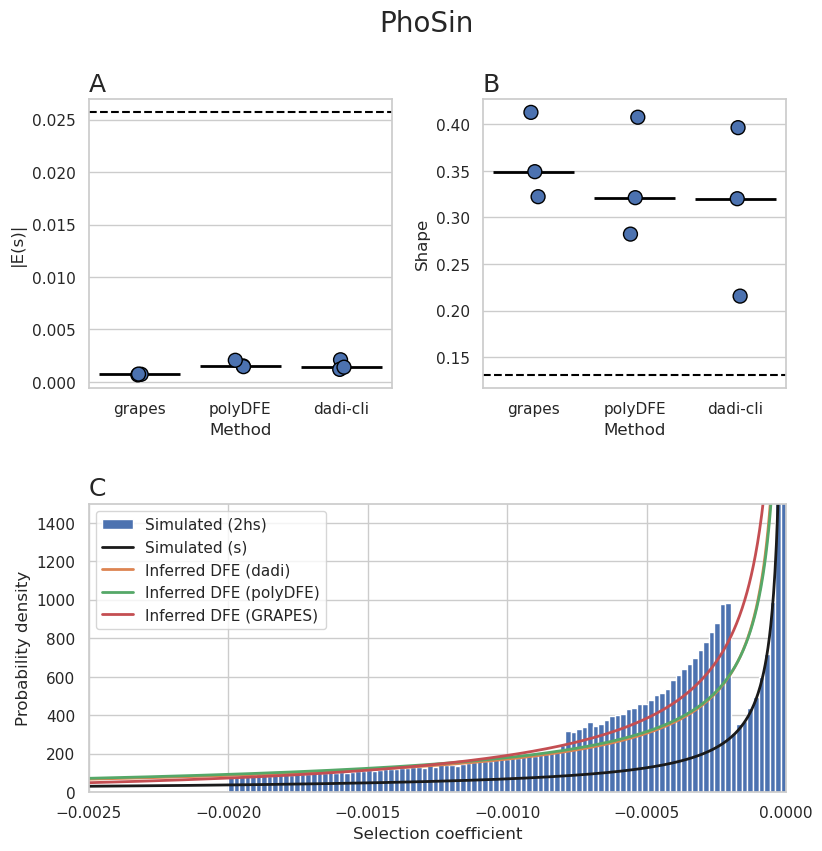

In [83]:
def existing_figure_for_mosaic():
    return {'figure': build_hs_plot()}

layout = [
    ['A', 'B'],
    ['C', 'C']
]

fig, axes = plt.subplot_mosaic(
    layout,
    figsize=(9, 9),
    #white space between subplots
    gridspec_kw={'wspace': 0.3, 'hspace': 0.4}
)

#plt.subplots_adjust(wspace=0.4, hspace=0.3)
#all_DFE = pd.concat([species_info.make_dfe(m) for m in ["grapes", "polyDFE", "dadi"]])
#make new name columns for viz
#all_DFE['pop'] = all_DFE['pop_id'].map(pop_dict)
#seaborn boxplot method vs. Es split by pop_id no lines, no error bars
import seaborn as sns
sns.set_theme(style="whitegrid")

#sns.boxplot(x="method", y="Es", hue = 'pop', data=pho_sin.all_DFE, ax = axes['A'])
sns.boxplot(x="method", y="Es", hue = 'pop', data=pho_sin.all_DFE, 
            showfliers=False,  # Hide outlier points
            showbox=False,     # Hide the box
            showcaps=False,    # Hide the caps
            whis=0,
            linewidth=2,
            linecolor='black',
            ax = axes['A'])

sns.stripplot(x="method", y="Es", hue = 'pop', data=pho_sin.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['A'])


#horizontal line at 0 on axes A
axes['A'].axhline(abs(pho_sin.dfe_params[0]), color='black', linestyle='--')
axes['A'].set_ylabel('|E(s)|')  
axes['A'].set_xlabel('Method')
axes['A'].set_title("A", loc = "left", fontsize=panel_size)
axes['A'].get_legend().remove()
#seaborn boxplot method vs. Es split by pop_id no lines, no error bars
sns.set_theme(style="whitegrid")

sns.boxplot(x="method", y="shape", hue = 'pop', data=pho_sin.all_DFE, 
            showfliers=False,  # Hide outlier points
            showbox=False,     # Hide the box
            showcaps=False,    # Hide the caps
            whis=0,
            linewidth=2,
            linecolor='black',
            ax = axes['B'])

sns.stripplot(x="method", y="shape", hue = 'pop', data=pho_sin.all_DFE, dodge=True, jitter = 0.05, alpha=1, linewidth=1, edgecolor='black',legend=False, size = 10, ax = axes['B'])

#horizontal line at 0
axes['B'].axhline(abs(pho_sin.dfe_params[1]), color='black', linestyle='--')
axes['B'].set_title("B", loc = "left", fontsize=panel_size)
axes['B'].set_ylabel('Shape')
axes['B'].set_xlabel('Method')
axes['B'].get_legend().remove()
build_hs_plot(axes['C'])
axes['C'].set_title("C", loc = "left", fontsize=panel_size)
fig.suptitle(f"{pho_sin.species}")
plt.savefig("PhoSin_Vaquita2Epoch_1R22_Gamma_R22_Phocoena_sinus.mPhoSin1.pri.110_exons_DFE_plot.pdf")

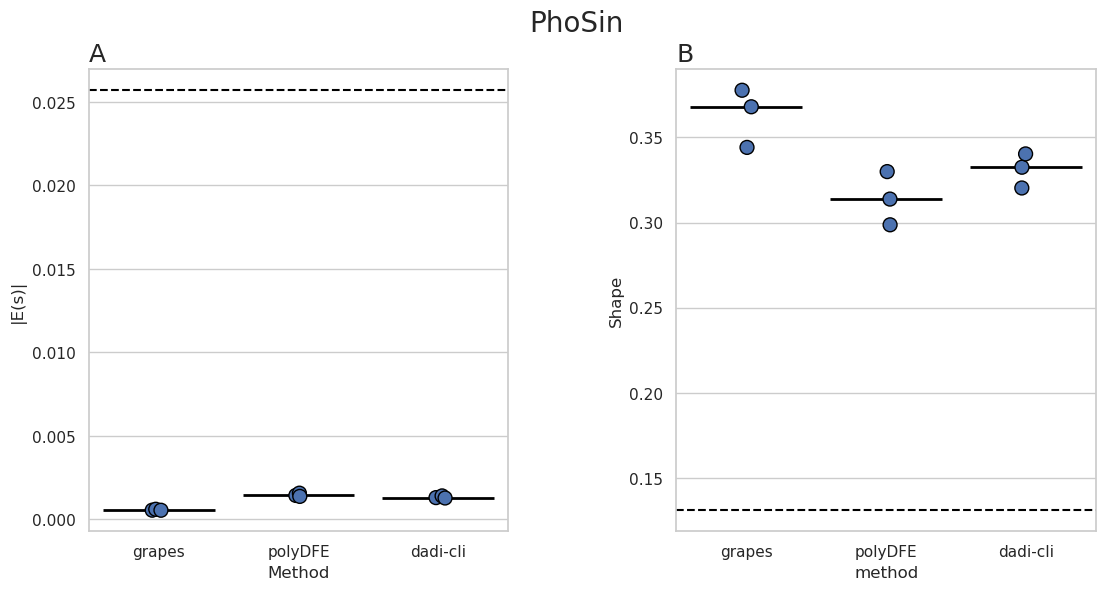

In [84]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Vaquita2Epoch_1R22",
    dfe = "Gamma_R22",
    annot = "all_sites"
)

make_some_plots(pho_sin, hide_legend = True)
loss_list.append(pho_sin.get_loss())

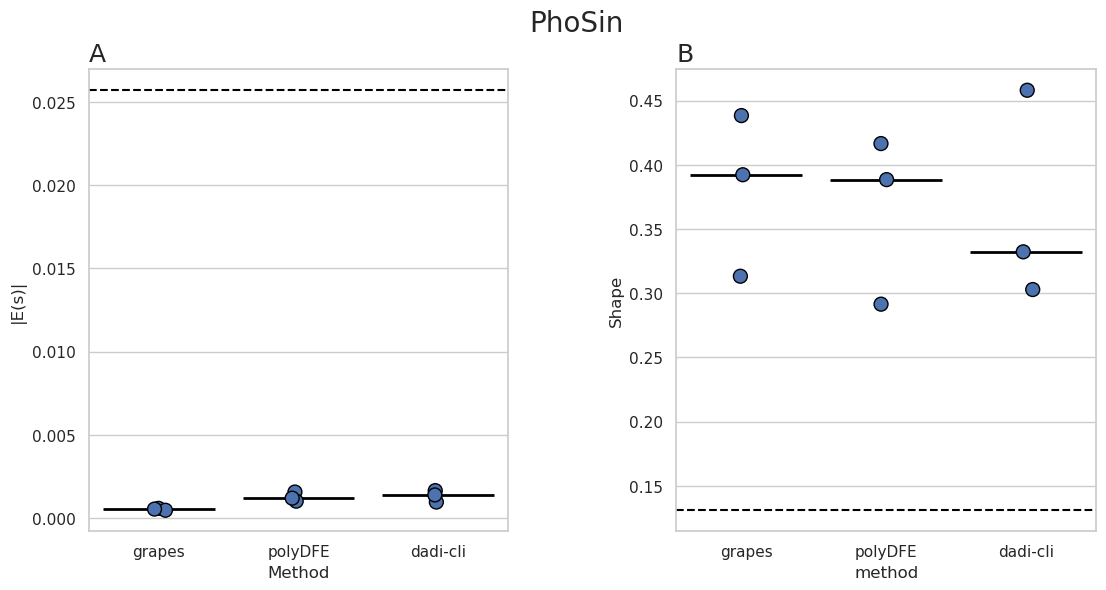

In [85]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Constant",
    dfe = "Gamma_R22",
    annot = "Phocoena_sinus.mPhoSin1.pri.110_exons"
)
make_some_plots(pho_sin, hide_legend = True)
loss_list.append(pho_sin.get_loss())

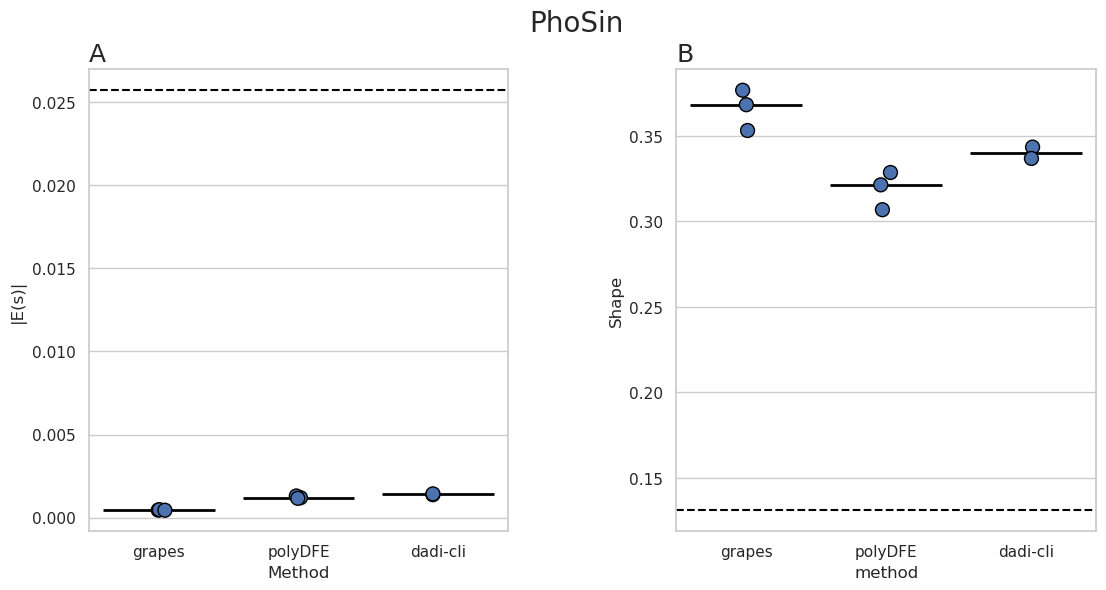

In [86]:
pho_sin = SpeciesInfo(
    species = "PhoSin",
    basedir = "PhoSin_results",
    demog = "Constant",
    dfe = "Gamma_R22",
    annot = "all_sites"
)
make_some_plots(pho_sin, hide_legend = True)
loss_list.append(pho_sin.get_loss())

In [87]:
from IPython.display import display
#pandas to latex table
loss_df = pd.concat(loss_list)

display(loss_df.sort_values(by = ['MAE E|s|', 'species ID', 'demography', 'method']).groupby('species ID').head(3))
print("")
display(loss_df.sort_values(by = ['MAE shape', 'species ID', 'demography', 'method']).groupby('species ID').head(3))

loss_df.to_latex()
print("")
loss_df.sort_values(by = ['MAE E|s|'])


loss_df.sort_values(by = ['species ID', 'demography', 'method', 'MAE E|s|', 'MAE shape']).to_latex(index = False)

,MAE E|s|,MAE shape,method,species ID,demography,annotation
0,0.001134,0.029696,dadi-cli,HomSap,Constant,ensembl_havana_104_exons
2,0.001773,0.014414,polyDFE,HomSap,Constant,all_sites
2,0.002344,0.006828,polyDFE,HomSap,Constant,ensembl_havana_104_exons
2,0.024026,0.205934,polyDFE,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons
0,0.024136,0.179650,dadi-cli,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons
2,0.024237,0.183145,polyDFE,PhoSin,Vaquita2Epoch_1R22,all_sites


,MAE E|s|,MAE shape,method,species ID,demography,annotation
0,0.002667,0.000712,dadi-cli,HomSap,Constant,all_sites
2,0.002344,0.006828,polyDFE,HomSap,Constant,ensembl_havana_104_exons
1,0.010063,0.008626,grapes,HomSap,Constant,ensembl_havana_104_exons
0,0.024136,0.179650,dadi-cli,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons
2,0.024237,0.183145,polyDFE,PhoSin,Vaquita2Epoch_1R22,all_sites
2,0.024476,0.187955,polyDFE,PhoSin,Constant,all_sites


'\\begin{tabular}{rrllll}\n\\toprule\nMAE E|s| & MAE shape & method & species ID & demography & annotation \\\\\n\\midrule\n0.001134 & 0.029696 & dadi-cli & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.002667 & 0.000712 & dadi-cli & HomSap & Constant & all_sites \\\\\n0.010063 & 0.008626 & grapes & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.011094 & 0.028638 & grapes & HomSap & Constant & all_sites \\\\\n0.001773 & 0.014414 & polyDFE & HomSap & Constant & all_sites \\\\\n0.002344 & 0.006828 & polyDFE & HomSap & Constant & ensembl_havana_104_exons \\\\\n0.011556 & 0.026502 & dadi-cli & HomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites \\\\\n0.013851 & 0.030905 & dadi-cli & HomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons \\\\\n0.011076 & 0.051345 & grapes & HomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons \\\\\n0.011841 & 0.055497 & grapes & HomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites \\\\\n0.007188 & 0.024394 & pol

In [88]:
pivot_df = loss_df.pivot_table(index=['species ID', 'demography', 'annotation'], 
                          columns='method', 
                          values=['MAE E|s|', 'MAE shape'])
pivot_df.columns = [f'{val}_{col}' for val, col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
display(pivot_df)
pivot_df.to_latex(index = False)


,species ID,demography,annotation,MAE E|s|_dadi-cli,MAE E|s|_grapes,MAE E|s|_polyDFE,MAE shape_dadi-cli,MAE shape_grapes,MAE shape_polyDFE
0,HomSap,Constant,all_sites,0.002667,0.011094,0.001773,0.000712,0.028638,0.014414
1,HomSap,Constant,ensembl_havana_104_exons,0.001134,0.010063,0.002344,0.029696,0.008626,0.006828
2,HomSap,OutOfAfricaArchaicAdmixture_5R19,all_sites,0.011556,0.011841,0.007422,0.026502,0.055497,0.035366
3,HomSap,OutOfAfricaArchaicAdmixture_5R19,ensembl_havana_104_exons,0.013851,0.011076,0.007188,0.030905,0.051345,0.024394
4,PhoSin,Constant,Phocoena_sinus.mPhoSin1.pri.110_exons,0.024365,0.025167,0.024439,0.233357,0.250249,0.234464
5,PhoSin,Constant,all_sites,0.024292,0.025238,0.024476,0.209159,0.235067,0.187955
6,PhoSin,Vaquita2Epoch_1R22,Phocoena_sinus.mPhoSin1.pri.110_exons,0.024136,0.024992,0.024026,0.179650,0.230358,0.205934
7,PhoSin,Vaquita2Epoch_1R22,all_sites,0.024367,0.025129,0.024237,0.200058,0.232308,0.183145


'\\begin{tabular}{lllrrrrrr}\n\\toprule\nspecies ID & demography & annotation & MAE E|s|_dadi-cli & MAE E|s|_grapes & MAE E|s|_polyDFE & MAE shape_dadi-cli & MAE shape_grapes & MAE shape_polyDFE \\\\\n\\midrule\nHomSap & Constant & all_sites & 0.002667 & 0.011094 & 0.001773 & 0.000712 & 0.028638 & 0.014414 \\\\\nHomSap & Constant & ensembl_havana_104_exons & 0.001134 & 0.010063 & 0.002344 & 0.029696 & 0.008626 & 0.006828 \\\\\nHomSap & OutOfAfricaArchaicAdmixture_5R19 & all_sites & 0.011556 & 0.011841 & 0.007422 & 0.026502 & 0.055497 & 0.035366 \\\\\nHomSap & OutOfAfricaArchaicAdmixture_5R19 & ensembl_havana_104_exons & 0.013851 & 0.011076 & 0.007188 & 0.030905 & 0.051345 & 0.024394 \\\\\nPhoSin & Constant & Phocoena_sinus.mPhoSin1.pri.110_exons & 0.024365 & 0.025167 & 0.024439 & 0.233357 & 0.250249 & 0.234464 \\\\\nPhoSin & Constant & all_sites & 0.024292 & 0.025238 & 0.024476 & 0.209159 & 0.235067 & 0.187955 \\\\\nPhoSin & Vaquita2Epoch_1R22 & Phocoena_sinus.mPhoSin1.pri.110_exons & 

In [89]:
print(np.min(loss_df[loss_df['species ID'] == "HomSap"]['MAE shape']))
np.min(loss_df[loss_df['species ID'] == "PhoSin"]['MAE shape'])  

0.0007116947786198017


0.17965044653508885